# 밑바닥 부터 시작하는 딥러닝

## 목차
```
6.1 매개변수 갱신 
__6.1.1 모험가 이야기 
__6.1.2 확률적 경사 하강법(SGD) 
__6.1.3 SGD의 단점 
__6.1.4 모멘텀 
__6.1.5 AdaGrad 
__6.1.6 Adam 
__6.1.7 어느 갱신 방법을 이용할 것인가? 
__6.1.8 MNIST 데이터셋으로 본 갱신 방법 비교 
6.2 가중치의 초깃값 
__6.2.1 초깃값을 0으로 하면? 
__6.2.2 은닉층의 활성화 분포 
__6.2.3 ReLU를 사용할 때의 가중치 초깃값 
__6.2.4 MNIST 데이터셋으로 본 가중치 초깃값 비교 
6.3 배치 정규화 
__6.3.1 배치 정규화 알고리즘 
__6.3.2 배치 정규화의 효과 
6.4 바른 학습을 위해 
__6.4.1 오버피팅 
__6.4.2 가중치 감소 
__6.4.3 드롭아웃 
6.5 적절한 하이퍼파라미터 값 찾기 
__6.5.1 검증 데이터 
__6.5.2 하이퍼파라미터 최적화 
__6.5.3 하이퍼파라미터 최적화 구현하기 
```
---

# Chapter 6: 학습 관련 기술들 

- 가중치 매개변수의 최적값을 탐색하는 최적화 방법
- 가중치 매개변수 초깃값, 하이퍼파라미터 설정 방법
- 오버피팅 대응책: 가중치 감소, 드롭아웃
- 배치 정규화

## 6.1 매개변수 갱신

- **최적화(optimization):** 매개변수의 최적값 찾는 문제(신경망 학습의 목적)
- 확률적 경사 하강법(SGD): 매개변수의 기울기(미분)를 구해, 기울어진 방향으로 매개변수 값을 갱신 반복
- SGD 보다 '똑똑한' 방법은?

### 6.1.1 모험가 이야기

- 광대하고 복잡한 지형을 지도도 없이 눈을 가린 채로 '깊은 곳'을 찾는법?
    - 단서: '기울기'
    - 지금 서 있는 장소에서 가장 크게 기울어진 방향으로 가자: SGD전략
    - 이 일을 반복하면 언젠가 '깊은 곳'에 찾아갈 수도..

### 6.1.2 확률적 경사 하강법(SGD)

- SGD는 기울어진 방향으로 일정 거리만 가겠다는 단순한 방법

    <img src = "../deep_learning_images/e 6.1.png" width = "40%" height = "40%" >

In [1]:
class SGD:
    def __init__(self, lr = 0.01):
        self.lr = lr
        
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]

In [ ]:
# pseudocode
network = TwoLayerNet(...)
optimizer = SGD() # 매개변수 갱신을 책임짐.
# 최적화를 담당하는 클래스를 분리해 구현하면 기능을 모듈화하기 좋다.
# optimizer = Momentum()

for i in range(10000):
    '''
    x_batch, t_batch = get_mini_batch # 미니배치
    grads = network.gradient(x_batch, t_batch)
    params = network.params
    optimizer.update(params, grads) # 매개변수(params)와 기울기(grads) 정보만 넘겨주면 된다
    '''

### 6.1.3 SGD의 단점

- 다음 함수의 최솟값은?

    <img src = "../deep_learning_images/e 6.2.png" width = "30%" height = "30%" >

<img src = "../deep_learning_images/fig 6-1.png" width = "60%" height = "60%" >

- 함수의 기울기
- 특징
    - y축 방향은 크고 x축 방향은 작다(y축 방향은 가파른데 x축 방향은 완만)
    - 최솟값(x,y)=(0,0) but, 기울기 대부분은 (0,0)을 가리키지 않는다
    

<img src = "../deep_learning_images/fig 6-2.png" width = "50%" height = "50%" >

- SGD에 의한 최적화 갱신 경로: 최솟값인 (0,0)까지 지그재그로 이동하니 비효울적( (-7.0,2.0)에서 탐색 시작 )


<img src = "../deep_learning_images/fig 6-3.png" width = "50%" height = "50%" >

- SGD의 단점: 비등방성(antisotropy)함수에서는 탐색 경로가 비효율적이다.
- 개선 기법
    - 모멘텀(Momentum)
    - AdaGrad
    - Adam

### 6.1.4 모멘텀

- 모멘텀(Momentum): '운동량'을 뜻하는 단어, 물리와 관계

<img src = "../deep_learning_images/e 6.3.png" width = "30%" height = "30%" >

<img src = "../deep_learning_images/e 6.4.png" width = "30%" height = "30%" >

- 갱신할 가중치 매개변수
- W에 대한 손실함수의 기울기
- 학습률
- v: 속도(velocity)
- 물체가 아무런 힘을 받지 않을 때 서서히 하강시키는 역할(지면 마찰, 공기 저항)

- 모멘텀의 이미지: 공이 그릇의 곡면(기울기)을 따라 구르듯 움직인다.

<img src = "../deep_learning_images/fig 6-4.png" width = "50%" height = "50%" >

In [8]:
class Momentum:
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v is None: # 처음 호출 될 때
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
                
        for key in params.keys():
            self.v[key] = self.mementum*self.v[key] - self.lr*grads[key]
            params[key] += self.v[key]

- 모멘텀에 의한 최적화 갱신 경로

<img src = "../deep_learning_images/fig 6-5.png" width = "50%" height = "50%" >

- 공이 바닥을 구르듯 움직인다.
- SGD와 비교해 '지그재그 정도'가 덜하다. 전체적으로 SGD보다 x축 방향으로 빠르게 다가간다.
- x축의 힘은 아주 작지만 방향은 변하지 않아서 한 방향으로 일정하게 가속하기 때문
- y축의 힘은 크지만 위아래로 번갈아 받아서 상충하여 y축 방향의 속도는 안정적이지 않다.

### 6.1.5 AdaGrad

- 신경망 학습에서의 학습률 값
    - 너무 작으면 -> 학습 시간이 길어짐
    - 너무 크면 -> 발산하여 학습X
- **학습률 감소(learning rate decay)**: 학습을 진행하면서 학습률을 점차 줄여가는 방법
- AdaGrad: '각각의' 매개변수에 '맞춤형'값을 만들어준다. 적응적으로(adaptive)학습률을 조정하면서 학습 진행

<img src = "../deep_learning_images/e 6.5.png" width = "40%" height = "40%" >

<img src = "../deep_learning_images/e 6.6.png" width = "40%" height = "40%" >

- h: 기존 기울기 값을 제곱하여 계속 더해준다. -> 매개변수 갱신할 때 다시 곱해 조정
- 매개변수의 원소 중에서 많이 움직인(크게 갱신된) 원소는 학습률이 낮아진다. -> 학습률 감소가 매개변수의 원소마다 다르게 적용됨을 뜻함

> AdaGrad: 과거의 기울기를 제곱하여 계속 더해간다. 학습을 진행할수록 갱신 강도가 약해짐. 실제로 무한히 계속 학습한다면 어느 순간 갱신량 0, 전혀 갱신되지 않는다. 이 문제를 개선한 기법 RMSProp 방법. 과거의 모든 기울기를 균일하게 더해가는 것이 아닌, 먼 과거의 기울기는 서서히 잊고 새로운 기울기 정보를 크게 반영. 이를 **지수이동평균(Exponential Moving Average, EMA)**이라 하며, 과거 기울기의 반영 규모를 기하급수적으로 감소시킨다.

In [11]:
class AdaGrad:
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
        
    def update(self, params, grads):
        if self.h is None: # 처음 호출 될 때
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
                
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7) # 0으로 나누는 사태 방지

- AdaGrad에 의한 최적화 갱신 경로

<img src = "../deep_learning_images/fig 6-6.png" width = "50%" height = "50%" >

- 최솟값을 향해 효율적으로 움직인다.
- y축 방향은 기울기가 커서 처음에는 크게 움직이지만, 그 큰 움직임에 비례해 갱신 정도도 큰 폭으로 작아지도록 조정된다.
- y축 방향으로 갱신 강도가 빠르게 약해지고, 지그재그 움직임이 줄어든다.

### 6.1.6 Adam

- Adam = Momentum + AdaGrad
    - 직관적으로 모멘텀과 AdaGrad를 융합
    - 하이퍼파라미터의 '편향 보정'이 진행됨(자세한 내용 원논문 참고)

- Adam에 의한 최적화 갱신 경로

<img src = "../deep_learning_images/fig 6-7.png" width = "50%" height = "50%" >

### 6.1.7 어느 갱신 방법을 이용할 것인가?

- 최적화 기법 비교: SGD, Momentum, AdaGrad, Adam

<img src = "../deep_learning_images/fig 6-8.png" width = "70%" height = "70%" >

- 풀어야 할 문제 / 하이퍼파라미터를 어떻게 설정 -> 결과 달라짐

### 6.1.8 MNIST 데이터셋으로 본 갱신 방법 비교

In [ ]:
# coding: utf-8
import os
import sys
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import *


# 0. MNIST 데이터 읽기==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1. 실험용 설정==========
optimizers = {}
optimizers['SGD'] = SGD()
optimizers['Momentum'] = Momentum()
optimizers['AdaGrad'] = AdaGrad()
optimizers['Adam'] = Adam()
#optimizers['RMSprop'] = RMSprop()

networks = {}
train_loss = {}
for key in optimizers.keys():
    networks[key] = MultiLayerNet(
        input_size=784, hidden_size_list=[100, 100, 100, 100],
        output_size=10)
    train_loss[key] = []    


# 2. 훈련 시작==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in optimizers.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizers[key].update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print( "===========" + "iteration:" + str(i) + "===========")
        for key in optimizers.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3. 그래프 그리기==========
markers = {"SGD": "o", "Momentum": "x", "AdaGrad": "s", "Adam": "D"}
x = np.arange(max_iterations)
for key in optimizers.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 1)
plt.legend()
plt.show()


- 각 층이 100개의 뉴런으로 구성된 5층 신경망에서 ReLU를 활성화 함수로 사용해 측정
    - SGD의 학습 진도가 가장 느리다. / 나머지 세 기법 비슷
    - 하이퍼파라미터(학습률, 신경망의 구조, 층 깊이)에 따라 결과가 달라진다
    - 일반적으로 SGD보다 다른 세 기법이 빠르게 학습하고, 때로는 최종 정확도도 높게 나타난다.

## 6.2 가중치의 초기값

### 6.2.1 초기값을 0으로 하면?

- **가중치 감소(weight decay)**: 가중치 매개변수의 값이 작아지도록 학습하는 방법 -> 오버피팅이 잃어나지 않게
- 가중치를 작게 만들고 싶다면 초깃값도 최대한 작은 값에서 시작하는 것이 정공법
    - 가중치 초기값을 모두 0 -> 오차역전파법에서 모든 가중치의 값이 똑같이 갱신되기 때문에 학습 X
    - '가중치가 고르게 되어버리는 상황(가중치의 대칭적인 구조를 무너뜨리려면)'을 막으려면 초기값을 무작위로 설정해야 한다.

### 6.2.2 은닉층의 활성화값 분포

- 은닉층의 활성화값의 분포를 관찰하면 중요한 정보를 얻을 수 있다.
    - 가중치의 초기값에 따라 은닉층 활성화값들이 어떻게 변화하는지
    - 활성화 함수: 시그모이드 함수
    - 5층 신경망, 각 층 뉴런 100개씩
    - 입력 데이터 1000개 정규분포로 무작위 생성 

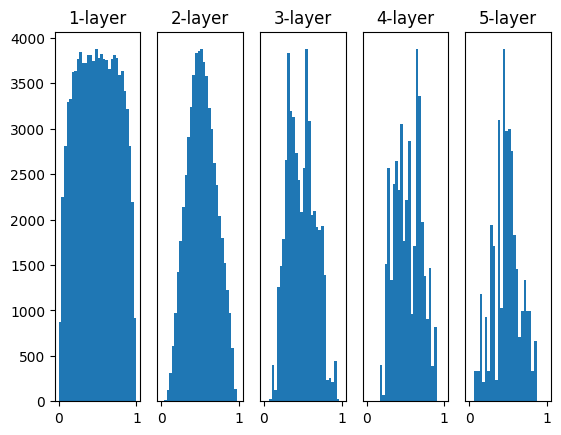

In [25]:
# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def ReLU(x):
    return np.maximum(0, x)


def tanh(x):
    return np.tanh(x)
    
input_data = np.random.randn(1000, 100)  # 1000개의 데이터
node_num = 100  # 각 은닉층의 노드(뉴런) 수
hidden_layer_size = 5  # 은닉층이 5개
activations = {}  # 이곳에 활성화 결과를 저장

x = input_data

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    # 초깃값을 다양하게 바꿔가며 실험해보자！ / 정규분포의 표준편차 변경
    # w = np.random.randn(node_num, node_num) * 1
    # w = np.random.randn(node_num, node_num) * 0.01
    # w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
    w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)


    a = np.dot(x, w)


    # 활성화 함수도 바꿔가며 실험해보자！
    z = sigmoid(a)
    # z = ReLU(a)
    # z = tanh(a)

    activations[i] = z

# 히스토그램 그리기
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()


- 가중치를 표준편차가 1인 정규분포로 초기화 할 때의 각 층의 활성화 값 분포
    - 0과 1에 치우쳐 분포
    - 출력이 0 or 1에 가까워 지자, 그 미분은 0에 다가간다
    - 역전파의 기울기 값이 점점 작아지다가 사라진다 -> **기울기 소실(gradient vanishing)**
    - 층을 깊게하는 딥러닝에서는 기울기 소실은 더 심각한 문제가 될 수 있다.

<img src = "../deep_learning_images/fig 6-10.png" width = "70%" height = "70%" >

- 가중치를 표준편차가 0.01인 정규분포로 초기화 할 때의 각 층의 활성화 값 분포
    - 0.5 부근 집중
    - 0과 1로 치우치진 않았으니 기울기 소실 문제 X
    - 다수의 뉴런이 거의 같은 값을 출력하고 있어, **표현력을 제한** -> 골고루 분포 되어야 한다...

<img src = "../deep_learning_images/fig 6-11.png" width = "70%" height = "70%" >

- Xavier 초깃값
    - 딥러닝 프레임워크들이 표준적으로 이용(Caffe)
    - 앞 층에 노드가 많을수록 대상 노드의 초깃값으로 설정하는 가중치가 좁게 퍼진다.

<img src = "../deep_learning_images/fig 6-12.png" width = "70%" height = "70%" >

- 가중치의 초깃값으로 'Xavier 초깃값'을 이용할 때의 각 층의 활성화 값 분포
    - 층이 깊어지면서 형태가 다소 일그러짐(대신 tanh 함수 사용, 원점 대칭 'S'자 모양 곡선 함수). 하지만, 앞에서 본 방식보다는 확실히 넓게 분포
    - 각 층에 흐르는 데이터는 적당히 퍼져 있으므로, 시그모이드 함수의 표현력도 제한받지 않고 학습이 효율적으로 이뤄질 것으로 기대 가능

<img src = "../deep_learning_images/fig 6-13.png" width = "70%" height = "70%" >

### 6.2.3 ReLU를 사용할 때의 가중치 초깃값

- Xavier 초깃값: 활성화 함수가 선형인 것을 전제로 이끈 결과
- **He 초깃값:** ReLU에 특화된 초깃값

- 활성화 함수로 ReLU를 사용한 경우의 가중치 초깃값에 따른 활성화값 분포 변환
    - std = 0.01 때의 각 층의 활성화값들은 아주 작은 값 -> 역전파 때 가중치의 기울기 역시 작아진다 -> 학습 X
    - Xavier 초깃값: 층이 깊어지면서 치우침이 조금씩 커진다 -> '기울기 소실'문제
    - He 초깃값: 모든 층에서 균일하게 분포 -> 적절한 값 기대 가능

<img src = "../deep_learning_images/fig 6-14.png" width = "70%" height = "70%" >

### 6.2.4 MNIST 데이터셋으로 본 가중치 초깃값 비교

- std = 0.01, Xavier 초깃값, He 초깃값 비교

===========iteration:0===========
std=0.01:2.3025312819217514
Xavier:2.3208137472417487
He:2.45955935828383
===========iteration:100===========
std=0.01:2.3018293973158164
Xavier:2.221757403918465
He:1.2537676929424686
===========iteration:200===========
std=0.01:2.3029141155829267
Xavier:2.0595296230920583
He:0.6795531354722986
===========iteration:300===========
std=0.01:2.3027098696966966
Xavier:1.6656994036837283
He:0.5866194795173549
===========iteration:400===========
std=0.01:2.302996323165591
Xavier:1.3285746564226368
He:0.5206049207561068
===========iteration:500===========
std=0.01:2.3006007829970194
Xavier:0.9984809480717213
He:0.45503261185959504
===========iteration:600===========
std=0.01:2.299282901818306
Xavier:0.7493258214491979
He:0.4114117149943654
===========iteration:700===========
std=0.01:2.3026503802293643
Xavier:0.6055682684353523
He:0.323565774071342
===========iteration:800===========
std=0.01:2.3033826312968895
Xavier:0.4452622303226377
He:0.2472173136197002

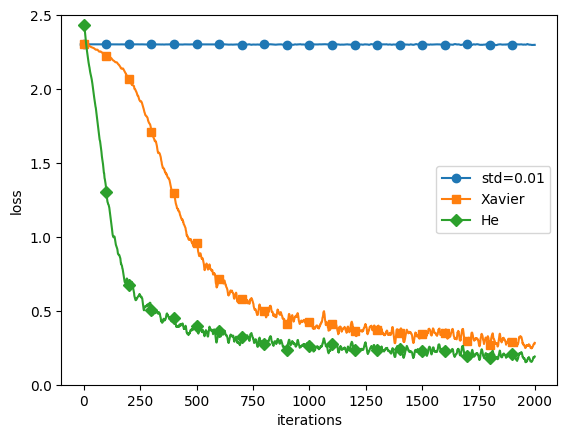

In [27]:
# coding: utf-8
import os
import sys

sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD


# 0. MNIST 데이터 읽기==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1. 실험용 설정==========
weight_init_types = {'std=0.01': 0.01, 'Xavier': 'sigmoid', 'He': 'relu'}
optimizer = SGD(lr=0.01)

networks = {}
train_loss = {}
for key, weight_type in weight_init_types.items():
    networks[key] = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100],
                                  output_size=10, weight_init_std=weight_type)
    train_loss[key] = []


# 2. 훈련 시작==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in weight_init_types.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizer.update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print("===========" + "iteration:" + str(i) + "===========")
        for key in weight_init_types.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3. 그래프 그리기==========
markers = {'std=0.01': 'o', 'Xavier': 's', 'He': 'D'}
x = np.arange(max_iterations)
for key in weight_init_types.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 2.5)
plt.legend()
plt.show()


- 뉴런 수 100개, 5층 신경망, 활성화 함수:ReLU
    - std=0.01: 학습이 전혀 이루어지지 않음. 순전파 때 너무 작은 값이 흐르기 때문. 역전파 때의 기울기도 작아져 가중치가 거의 갱신되지 않음.
    - Xavier, He: 학습 이루어짐. 학습 진도는 He 초깃값 쪽이 더 빠름.
- 어떤 일이든 시작(초깃값)이 중요한 법

## 6.3 배치 정규화

- **배치 정규화(Batch Normalization):** 각 층이 활성화를 적당히 퍼뜨리도록 '강제'하기

- 배치정규화: 2015년에 제안된 방법
- 주목받는 이유
    - 학습을 빨리 진행할 수 있다(학습 속도 개선).
    - 초깃값에 크게 의존하지 않는다(골치 아픈 초깃값 선택 개선).
    - 오버피팅을 억제한다(드롭아웃 등의 필요성 감소).

- 데이터 분포를 정규화하는 '배치 정규화(Batch Norm) 계층'을 신경망에 삽입

<img src = "../deep_learning_images/fig 6-16.png" width = "70%" height = "70%" >

- 학습 시 미니배치 단위로 정규화
- 데이터 분포가 평균이 0, 분산이 1이 되도록 정규화

<img src = "../deep_learning_images/e 6.7.png" width = "40%" height = "40%" >

- 미니배치 입력 데이터 {x1, x2, x3, .. xm}이라는 m개의 입력 데이터의 집합에 대해 평균과 분산을 구함
- 입력 데이터를 평균이 0, 분산이 1이 되게 정규화
- 엡실론(epslion)은 작은 값(10e-7)으로, 0으로 나누는 사태 예방
- 평균 0, 분산 1인 데이터로 변환 -> 이 처리를 활성화 함수의 앞(혹은 뒤)에 삽입함으로써 데이터 분포가 덜 치우치게 할 수 있다.

- 배치 정규화 계층마다 이 정규화된 데이터에 고유한 확대(scale)와 이동(shift)변환 수행

<img src = "../deep_learning_images/e 6.8.png" width = "30%" height = "30%" >

- 처음 확대(감마)=1, 이동(베타)=0 시작. 학습하면서 적합한 값으로 조정

- 배치 정규화의 계산 그래프

<img src = "../deep_learning_images/fig 6-17.png" width = "70%" height = "70%" >

### 6.3.2 배치 정규화의 효과

============== 1/16 ==============
epoch:0 | 0.1 - 0.105


/Users/hongminsik/Desktop/DeepLearning_fromScratch/common/functions.py:34: RuntimeWarning: invalid value encountered in subtract
  x = x - np.max(x, axis=0)


epoch:1 | 0.097 - 0.116
epoch:2 | 0.097 - 0.131
epoch:3 | 0.097 - 0.161
epoch:4 | 0.097 - 0.186
epoch:5 | 0.097 - 0.2
epoch:6 | 0.097 - 0.219
epoch:7 | 0.097 - 0.246
epoch:8 | 0.097 - 0.262
epoch:9 | 0.097 - 0.274
epoch:10 | 0.097 - 0.295
epoch:11 | 0.097 - 0.314
epoch:12 | 0.097 - 0.336
epoch:13 | 0.097 - 0.359
epoch:14 | 0.097 - 0.358
epoch:15 | 0.097 - 0.379
epoch:16 | 0.097 - 0.392
epoch:17 | 0.097 - 0.399
epoch:18 | 0.097 - 0.419


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch:19 | 0.097 - 0.427
============== 2/16 ==============
epoch:0 | 0.097 - 0.106


/Users/hongminsik/Desktop/DeepLearning_fromScratch/common/multi_layer_net_extend.py:104: RuntimeWarning: overflow encountered in square
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)
/Users/hongminsik/Desktop/DeepLearning_fromScratch/common/multi_layer_net_extend.py:104: RuntimeWarning: invalid value encountered in scalar multiply
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)


epoch:1 | 0.097 - 0.091
epoch:2 | 0.097 - 0.101
epoch:3 | 0.097 - 0.125
epoch:4 | 0.097 - 0.146
epoch:5 | 0.097 - 0.168
epoch:6 | 0.097 - 0.207
epoch:7 | 0.097 - 0.229
epoch:8 | 0.097 - 0.253
epoch:9 | 0.097 - 0.267
epoch:10 | 0.097 - 0.298
epoch:11 | 0.097 - 0.317
epoch:12 | 0.097 - 0.335
epoch:13 | 0.097 - 0.365
epoch:14 | 0.097 - 0.383
epoch:15 | 0.097 - 0.394
epoch:16 | 0.097 - 0.413
epoch:17 | 0.097 - 0.43
epoch:18 | 0.097 - 0.436


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch:19 | 0.097 - 0.451
============== 3/16 ==============
epoch:0 | 0.135 - 0.091
epoch:1 | 0.382 - 0.109
epoch:2 | 0.513 - 0.17
epoch:3 | 0.605 - 0.209
epoch:4 | 0.627 - 0.227
epoch:5 | 0.708 - 0.255
epoch:6 | 0.756 - 0.287
epoch:7 | 0.784 - 0.316
epoch:8 | 0.823 - 0.349
epoch:9 | 0.855 - 0.37
epoch:10 | 0.892 - 0.407
epoch:11 | 0.904 - 0.425
epoch:12 | 0.923 - 0.462
epoch:13 | 0.942 - 0.495
epoch:14 | 0.941 - 0.513
epoch:15 | 0.954 - 0.544
epoch:16 | 0.965 - 0.553
epoch:17 | 0.97 - 0.584
epoch:18 | 0.974 - 0.606


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch:19 | 0.98 - 0.616
============== 4/16 ==============
epoch:0 | 0.093 - 0.092
epoch:1 | 0.246 - 0.144
epoch:2 | 0.406 - 0.213
epoch:3 | 0.523 - 0.275
epoch:4 | 0.612 - 0.348
epoch:5 | 0.668 - 0.429
epoch:6 | 0.694 - 0.477
epoch:7 | 0.721 - 0.536
epoch:8 | 0.751 - 0.575
epoch:9 | 0.766 - 0.621
epoch:10 | 0.778 - 0.646
epoch:11 | 0.796 - 0.675
epoch:12 | 0.8 - 0.701
epoch:13 | 0.814 - 0.724
epoch:14 | 0.833 - 0.742
epoch:15 | 0.826 - 0.76
epoch:16 | 0.85 - 0.775
epoch:17 | 0.849 - 0.79
epoch:18 | 0.858 - 0.801


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch:19 | 0.873 - 0.815
============== 5/16 ==============
epoch:0 | 0.081 - 0.082
epoch:1 | 0.085 - 0.152
epoch:2 | 0.098 - 0.276
epoch:3 | 0.101 - 0.391
epoch:4 | 0.125 - 0.505
epoch:5 | 0.133 - 0.58
epoch:6 | 0.138 - 0.65
epoch:7 | 0.152 - 0.703
epoch:8 | 0.159 - 0.727
epoch:9 | 0.181 - 0.754
epoch:10 | 0.218 - 0.778
epoch:11 | 0.227 - 0.797
epoch:12 | 0.246 - 0.821
epoch:13 | 0.264 - 0.834
epoch:14 | 0.277 - 0.853
epoch:15 | 0.274 - 0.855
epoch:16 | 0.277 - 0.864
epoch:17 | 0.272 - 0.875
epoch:18 | 0.27 - 0.884


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch:19 | 0.285 - 0.899
============== 6/16 ==============
epoch:0 | 0.089 - 0.121
epoch:1 | 0.119 - 0.276
epoch:2 | 0.128 - 0.434
epoch:3 | 0.144 - 0.553
epoch:4 | 0.139 - 0.645
epoch:5 | 0.118 - 0.703
epoch:6 | 0.114 - 0.757
epoch:7 | 0.117 - 0.796
epoch:8 | 0.117 - 0.824
epoch:9 | 0.117 - 0.849
epoch:10 | 0.115 - 0.865
epoch:11 | 0.117 - 0.878
epoch:12 | 0.117 - 0.894
epoch:13 | 0.117 - 0.905
epoch:14 | 0.117 - 0.909
epoch:15 | 0.117 - 0.92
epoch:16 | 0.117 - 0.93
epoch:17 | 0.117 - 0.933
epoch:18 | 0.117 - 0.941


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch:19 | 0.117 - 0.949
============== 7/16 ==============
epoch:0 | 0.094 - 0.129
epoch:1 | 0.116 - 0.299
epoch:2 | 0.116 - 0.551
epoch:3 | 0.117 - 0.71
epoch:4 | 0.117 - 0.755
epoch:5 | 0.117 - 0.806
epoch:6 | 0.117 - 0.849
epoch:7 | 0.117 - 0.88
epoch:8 | 0.117 - 0.893
epoch:9 | 0.117 - 0.91
epoch:10 | 0.168 - 0.929
epoch:11 | 0.117 - 0.944
epoch:12 | 0.117 - 0.956
epoch:13 | 0.117 - 0.969
epoch:14 | 0.117 - 0.973
epoch:15 | 0.117 - 0.975
epoch:16 | 0.117 - 0.98
epoch:17 | 0.117 - 0.98
epoch:18 | 0.117 - 0.984


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch:19 | 0.117 - 0.987
============== 8/16 ==============
epoch:0 | 0.117 - 0.127
epoch:1 | 0.117 - 0.45
epoch:2 | 0.117 - 0.648
epoch:3 | 0.116 - 0.726
epoch:4 | 0.116 - 0.797
epoch:5 | 0.116 - 0.865
epoch:6 | 0.116 - 0.889
epoch:7 | 0.116 - 0.925
epoch:8 | 0.116 - 0.945
epoch:9 | 0.116 - 0.966
epoch:10 | 0.116 - 0.98
epoch:11 | 0.116 - 0.984
epoch:12 | 0.116 - 0.992
epoch:13 | 0.116 - 0.994
epoch:14 | 0.117 - 0.996
epoch:15 | 0.117 - 0.995
epoch:16 | 0.116 - 0.996
epoch:17 | 0.117 - 0.998
epoch:18 | 0.116 - 0.998


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch:19 | 0.117 - 0.998
============== 9/16 ==============
epoch:0 | 0.099 - 0.093
epoch:1 | 0.105 - 0.544
epoch:2 | 0.117 - 0.705
epoch:3 | 0.117 - 0.801
epoch:4 | 0.117 - 0.865
epoch:5 | 0.117 - 0.938
epoch:6 | 0.117 - 0.965
epoch:7 | 0.117 - 0.976
epoch:8 | 0.117 - 0.985
epoch:9 | 0.117 - 0.955
epoch:10 | 0.117 - 0.994
epoch:11 | 0.117 - 0.997
epoch:12 | 0.117 - 0.999
epoch:13 | 0.117 - 1.0
epoch:14 | 0.117 - 1.0
epoch:15 | 0.117 - 1.0
epoch:16 | 0.117 - 1.0
epoch:17 | 0.117 - 1.0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch:18 | 0.117 - 1.0
epoch:19 | 0.117 - 1.0
============== 10/16 ==============
epoch:0 | 0.116 - 0.13
epoch:1 | 0.099 - 0.496
epoch:2 | 0.117 - 0.799
epoch:3 | 0.117 - 0.843
epoch:4 | 0.116 - 0.889
epoch:5 | 0.105 - 0.922
epoch:6 | 0.117 - 0.905
epoch:7 | 0.117 - 0.96
epoch:8 | 0.116 - 0.979
epoch:9 | 0.116 - 0.981
epoch:10 | 0.116 - 0.991
epoch:11 | 0.116 - 0.991
epoch:12 | 0.116 - 0.814
epoch:13 | 0.116 - 0.992
epoch:14 | 0.117 - 0.995
epoch:15 | 0.117 - 0.994
epoch:16 | 0.116 - 0.998
epoch:17 | 0.116 - 0.998
epoch:18 | 0.116 - 0.998


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch:19 | 0.116 - 0.998
============== 11/16 ==============
epoch:0 | 0.093 - 0.181
epoch:1 | 0.117 - 0.535
epoch:2 | 0.116 - 0.609
epoch:3 | 0.116 - 0.743
epoch:4 | 0.116 - 0.757
epoch:5 | 0.116 - 0.729
epoch:6 | 0.116 - 0.784
epoch:7 | 0.116 - 0.836
epoch:8 | 0.116 - 0.932
epoch:9 | 0.116 - 0.967
epoch:10 | 0.116 - 0.965
epoch:11 | 0.116 - 0.979
epoch:12 | 0.116 - 0.983
epoch:13 | 0.116 - 0.988
epoch:14 | 0.116 - 0.986
epoch:15 | 0.116 - 0.985
epoch:16 | 0.116 - 0.989
epoch:17 | 0.116 - 0.991
epoch:18 | 0.116 - 0.991


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch:19 | 0.116 - 0.989
============== 12/16 ==============
epoch:0 | 0.117 - 0.183
epoch:1 | 0.117 - 0.348
epoch:2 | 0.117 - 0.7
epoch:3 | 0.117 - 0.681
epoch:4 | 0.117 - 0.724
epoch:5 | 0.116 - 0.743
epoch:6 | 0.116 - 0.752
epoch:7 | 0.116 - 0.779
epoch:8 | 0.116 - 0.791
epoch:9 | 0.116 - 0.799
epoch:10 | 0.116 - 0.799
epoch:11 | 0.116 - 0.822
epoch:12 | 0.117 - 0.817
epoch:13 | 0.117 - 0.852
epoch:14 | 0.116 - 0.869
epoch:15 | 0.116 - 0.937
epoch:16 | 0.116 - 0.888
epoch:17 | 0.116 - 0.887
epoch:18 | 0.116 - 0.907


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch:19 | 0.116 - 0.979
============== 13/16 ==============
epoch:0 | 0.117 - 0.167
epoch:1 | 0.117 - 0.357
epoch:2 | 0.105 - 0.635
epoch:3 | 0.105 - 0.741
epoch:4 | 0.105 - 0.768
epoch:5 | 0.105 - 0.759
epoch:6 | 0.117 - 0.789
epoch:7 | 0.117 - 0.804
epoch:8 | 0.117 - 0.852
epoch:9 | 0.117 - 0.857
epoch:10 | 0.117 - 0.823
epoch:11 | 0.117 - 0.89
epoch:12 | 0.117 - 0.894
epoch:13 | 0.117 - 0.899
epoch:14 | 0.117 - 0.9
epoch:15 | 0.117 - 0.901
epoch:16 | 0.117 - 0.901
epoch:17 | 0.117 - 0.863
epoch:18 | 0.117 - 0.905


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch:19 | 0.117 - 0.903
============== 14/16 ==============
epoch:0 | 0.099 - 0.101
epoch:1 | 0.116 - 0.381
epoch:2 | 0.116 - 0.461
epoch:3 | 0.116 - 0.457
epoch:4 | 0.116 - 0.473
epoch:5 | 0.116 - 0.496
epoch:6 | 0.116 - 0.508
epoch:7 | 0.116 - 0.51
epoch:8 | 0.116 - 0.511
epoch:9 | 0.116 - 0.509
epoch:10 | 0.117 - 0.516
epoch:11 | 0.116 - 0.507
epoch:12 | 0.116 - 0.52
epoch:13 | 0.116 - 0.531
epoch:14 | 0.116 - 0.523
epoch:15 | 0.116 - 0.527
epoch:16 | 0.117 - 0.481
epoch:17 | 0.117 - 0.519
epoch:18 | 0.117 - 0.633


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch:19 | 0.117 - 0.661
============== 15/16 ==============
epoch:0 | 0.1 - 0.159
epoch:1 | 0.116 - 0.327
epoch:2 | 0.116 - 0.402
epoch:3 | 0.116 - 0.183
epoch:4 | 0.116 - 0.489
epoch:5 | 0.116 - 0.494
epoch:6 | 0.116 - 0.503
epoch:7 | 0.117 - 0.498
epoch:8 | 0.117 - 0.508
epoch:9 | 0.117 - 0.503
epoch:10 | 0.117 - 0.511
epoch:11 | 0.117 - 0.519
epoch:12 | 0.117 - 0.531
epoch:13 | 0.116 - 0.528
epoch:14 | 0.116 - 0.526
epoch:15 | 0.116 - 0.531
epoch:16 | 0.117 - 0.534
epoch:17 | 0.116 - 0.534
epoch:18 | 0.116 - 0.531


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch:19 | 0.116 - 0.531
============== 16/16 ==============
epoch:0 | 0.087 - 0.161
epoch:1 | 0.117 - 0.239
epoch:2 | 0.117 - 0.293
epoch:3 | 0.117 - 0.319
epoch:4 | 0.117 - 0.278
epoch:5 | 0.117 - 0.322
epoch:6 | 0.117 - 0.323
epoch:7 | 0.117 - 0.322
epoch:8 | 0.117 - 0.323
epoch:9 | 0.117 - 0.324
epoch:10 | 0.117 - 0.402
epoch:11 | 0.117 - 0.42
epoch:12 | 0.117 - 0.402
epoch:13 | 0.117 - 0.411
epoch:14 | 0.117 - 0.406
epoch:15 | 0.117 - 0.42
epoch:16 | 0.116 - 0.416
epoch:17 | 0.116 - 0.416
epoch:18 | 0.117 - 0.409
epoch:19 | 0.117 - 0.497


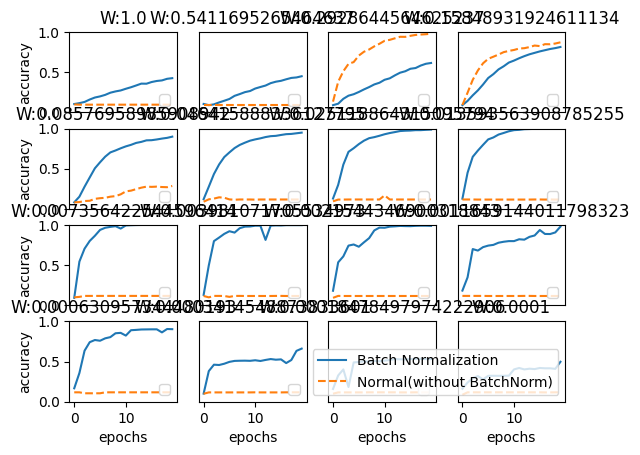

In [30]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net_extend import MultiLayerNetExtend
from common.optimizer import SGD, Adam

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 학습 데이터를 줄임
x_train = x_train[:1000]
t_train = t_train[:1000]

max_epochs = 20
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.01


def __train(weight_init_std):
    bn_network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10, 
                                    weight_init_std=weight_init_std, use_batchnorm=True)
    network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10,
                                weight_init_std=weight_init_std)
    optimizer = SGD(lr=learning_rate)
    
    train_acc_list = []
    bn_train_acc_list = []
    
    iter_per_epoch = max(train_size / batch_size, 1)
    epoch_cnt = 0
    
    for i in range(1000000000):
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]
    
        for _network in (bn_network, network):
            grads = _network.gradient(x_batch, t_batch)
            optimizer.update(_network.params, grads)
    
        if i % iter_per_epoch == 0:
            train_acc = network.accuracy(x_train, t_train)
            bn_train_acc = bn_network.accuracy(x_train, t_train)
            train_acc_list.append(train_acc)
            bn_train_acc_list.append(bn_train_acc)
    
            print("epoch:" + str(epoch_cnt) + " | " + str(train_acc) + " - " + str(bn_train_acc))
    
            epoch_cnt += 1
            if epoch_cnt >= max_epochs:
                break
                
    return train_acc_list, bn_train_acc_list


# 그래프 그리기==========
weight_scale_list = np.logspace(0, -4, num=16)
x = np.arange(max_epochs)

for i, w in enumerate(weight_scale_list):
    print( "============== " + str(i+1) + "/16" + " ==============")
    train_acc_list, bn_train_acc_list = __train(w)
    
    plt.subplot(4,4,i+1)
    plt.title("W:" + str(w))
    if i == 15:
        plt.plot(x, bn_train_acc_list, label='Batch Normalization', markevery=2)
        plt.plot(x, train_acc_list, linestyle = "--", label='Normal(without BatchNorm)', markevery=2)
    else:
        plt.plot(x, bn_train_acc_list, markevery=2)
        plt.plot(x, train_acc_list, linestyle="--", markevery=2)

    plt.ylim(0, 1.0)
    if i % 4:
        plt.yticks([])
    else:
        plt.ylabel("accuracy")
    if i < 12:
        plt.xticks([])
    else:
        plt.xlabel("epochs")
    plt.legend(loc='lower right')
    
plt.show()


- 배치 정규화의 효과: 배치 정규화가 학습 속도를 높인다.

<img src = "../deep_learning_images/fig 6-18.png" width = "70%" height = "70%" >

- 실선이 배치 정규화를 사용한 경우, 점선이 사용하지 않은 경우, 가중치 초깃값의 표준편차는 각 그래프 위 표기

<img src = "../deep_learning_images/fig 6-19.png" width = "70%" height = "70%" >

## 6.4 바른 학습을 위해

- 기계학습에서 **오버피팅**문제
    - 신경망이 훈련 데이터에만 지나치게 적응되어 그 외의 데이터에는 제대로 대응하지 못하는 상태
    - 오버피팅 억제 -> 범용 성능 지향

### 6.4.1 오버피팅

- 오버피팅이 주로 일어나는 경우
    1. 매개변수가 많고 표현력이 높은 모델
    2. 훈련 데이터가 적음

epoch:0, train acc:0.13666666666666666, test acc:0.1137
epoch:1, train acc:0.15, test acc:0.1312
epoch:2, train acc:0.16666666666666666, test acc:0.1398
epoch:3, train acc:0.19333333333333333, test acc:0.1551
epoch:4, train acc:0.22, test acc:0.1772
epoch:5, train acc:0.24333333333333335, test acc:0.2048
epoch:6, train acc:0.26666666666666666, test acc:0.2208
epoch:7, train acc:0.3333333333333333, test acc:0.2474
epoch:8, train acc:0.35, test acc:0.2631
epoch:9, train acc:0.37333333333333335, test acc:0.2852
epoch:10, train acc:0.4, test acc:0.2953
epoch:11, train acc:0.4066666666666667, test acc:0.2887
epoch:12, train acc:0.42333333333333334, test acc:0.3112
epoch:13, train acc:0.43, test acc:0.313
epoch:14, train acc:0.49333333333333335, test acc:0.3596
epoch:15, train acc:0.5066666666666667, test acc:0.3577
epoch:16, train acc:0.5333333333333333, test acc:0.3728
epoch:17, train acc:0.5366666666666666, test acc:0.3743
epoch:18, train acc:0.5433333333333333, test acc:0.3833
epoch:19, 

epoch:169, train acc:1.0, test acc:0.7416
epoch:170, train acc:1.0, test acc:0.7411
epoch:171, train acc:1.0, test acc:0.7417
epoch:172, train acc:1.0, test acc:0.7399
epoch:173, train acc:1.0, test acc:0.743
epoch:174, train acc:1.0, test acc:0.7419
epoch:175, train acc:1.0, test acc:0.7409
epoch:176, train acc:1.0, test acc:0.7419
epoch:177, train acc:1.0, test acc:0.7431
epoch:178, train acc:1.0, test acc:0.7425
epoch:179, train acc:1.0, test acc:0.7412
epoch:180, train acc:1.0, test acc:0.7424
epoch:181, train acc:1.0, test acc:0.7437
epoch:182, train acc:1.0, test acc:0.7423
epoch:183, train acc:1.0, test acc:0.7419
epoch:184, train acc:1.0, test acc:0.7447
epoch:185, train acc:1.0, test acc:0.7451
epoch:186, train acc:1.0, test acc:0.7453
epoch:187, train acc:1.0, test acc:0.7404
epoch:188, train acc:1.0, test acc:0.7398
epoch:189, train acc:1.0, test acc:0.7415
epoch:190, train acc:1.0, test acc:0.7401
epoch:191, train acc:1.0, test acc:0.7404
epoch:192, train acc:1.0, test acc:

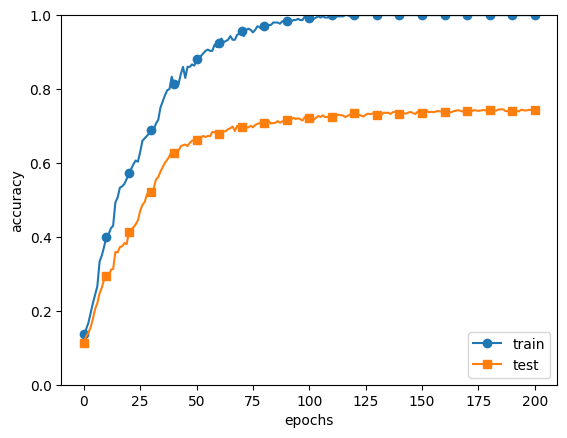

In [33]:
# coding: utf-8
import os
import sys

sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet # 가중치 감소를 적용한 네트워크
from common.optimizer import SGD

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 오버피팅을 재현하기 위해 학습 데이터 수를 줄임 -> 300개
x_train = x_train[:300]
t_train = t_train[:300]

# weight decay（가중치 감쇠） 설정 =======================
weight_decay_lambda = 0 # weight decay를 사용하지 않을 경우
# weight_decay_lambda = 0.1
# ====================================================

# 7층 네트워크를 사용해 네트워크 복잡성 높임 / 각 층 뉴런 100개 / 활성화 함수:ReLU
network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10,
                        weight_decay_lambda=weight_decay_lambda)
optimizer = SGD(lr=0.01) # 학습률이 0.01인 SGD로 매개변수 갱신

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        print("epoch:" + str(epoch_cnt) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc))

        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break


# 그래프 그리기==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

- 훈련 데이터(train)와 시험 데이터(test)의 에폭별 정확도 추이
- 60,000 MNIST 데이터셋 -> 훈련 데이터 중 300개, 7층 네트워크, 각층 뉴런 100개, 활성화 함수 ReLU
- 훈련 데이터 100에폭 이후 부터 정확도 거의 100%
- 시험 데이터에 대해서는 큰 차이: 훈련 데이터에만 적응(fitting), 범용 데이터에 제대로 대응하지 못함

### 6.4.2 가중치 감소

- **가중치 감소(weight decay):** 학습 과정에서 큰 가중치에 대해서는 그에 상응하는 큰 페널티를 부과하여 오버피팅을 억제하는 방법
    - 가중치의 제곱 노름(norm, L2노름)을 손실 함수에 더한다 -> 가중치가 커지는 것을 억제
    - 하이퍼파라미터를 크게 설정할수록 큰 가중치에 대한 페널티가 커진다.

epoch:0, train acc:0.05, test acc:0.0781
epoch:1, train acc:0.06, test acc:0.0867
epoch:2, train acc:0.10333333333333333, test acc:0.0927
epoch:3, train acc:0.14, test acc:0.1107
epoch:4, train acc:0.16666666666666666, test acc:0.137
epoch:5, train acc:0.18666666666666668, test acc:0.1599
epoch:6, train acc:0.24, test acc:0.1791
epoch:7, train acc:0.2833333333333333, test acc:0.2005
epoch:8, train acc:0.31, test acc:0.2198
epoch:9, train acc:0.35333333333333333, test acc:0.2401
epoch:10, train acc:0.3566666666666667, test acc:0.2541
epoch:11, train acc:0.38333333333333336, test acc:0.2692
epoch:12, train acc:0.42, test acc:0.2898
epoch:13, train acc:0.4266666666666667, test acc:0.297
epoch:14, train acc:0.44, test acc:0.3092
epoch:15, train acc:0.43333333333333335, test acc:0.3123
epoch:16, train acc:0.44666666666666666, test acc:0.3149
epoch:17, train acc:0.45666666666666667, test acc:0.3281
epoch:18, train acc:0.46, test acc:0.331
epoch:19, train acc:0.4666666666666667, test acc:0.34

epoch:159, train acc:0.8466666666666667, test acc:0.703
epoch:160, train acc:0.8466666666666667, test acc:0.6966
epoch:161, train acc:0.8466666666666667, test acc:0.6967
epoch:162, train acc:0.8466666666666667, test acc:0.7004
epoch:163, train acc:0.8433333333333334, test acc:0.6963
epoch:164, train acc:0.8433333333333334, test acc:0.7011
epoch:165, train acc:0.8466666666666667, test acc:0.694
epoch:166, train acc:0.85, test acc:0.6992
epoch:167, train acc:0.8466666666666667, test acc:0.6998
epoch:168, train acc:0.84, test acc:0.708
epoch:169, train acc:0.85, test acc:0.6933
epoch:170, train acc:0.86, test acc:0.7048
epoch:171, train acc:0.84, test acc:0.6953
epoch:172, train acc:0.83, test acc:0.6873
epoch:173, train acc:0.8333333333333334, test acc:0.6933
epoch:174, train acc:0.85, test acc:0.6992
epoch:175, train acc:0.8533333333333334, test acc:0.701
epoch:176, train acc:0.8433333333333334, test acc:0.7034
epoch:177, train acc:0.8566666666666667, test acc:0.7059
epoch:178, train ac

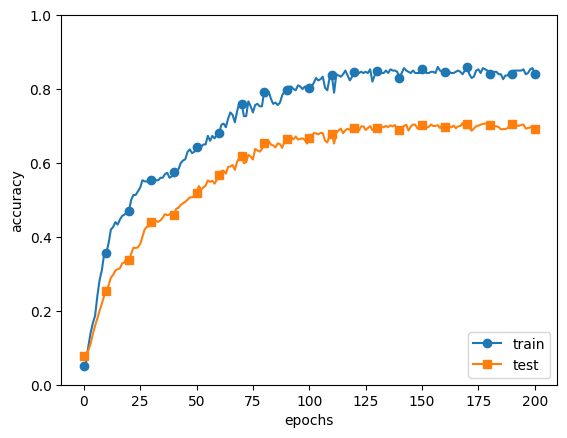

In [31]:
# coding: utf-8
import os
import sys

sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet # 가중치 감소를 적용한 네트워크
from common.optimizer import SGD

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 오버피팅을 재현하기 위해 학습 데이터 수를 줄임 -> 300개
x_train = x_train[:300]
t_train = t_train[:300]

# weight decay（가중치 감쇠） 설정 =======================
# weight_decay_lambda = 0 # weight decay를 사용하지 않을 경우
weight_decay_lambda = 0.1
# ====================================================

# 7층 네트워크를 사용해 네트워크 복잡성 높임 / 각 층 뉴런 100개 / 활성화 함수:ReLU
network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10,
                        weight_decay_lambda=weight_decay_lambda)
optimizer = SGD(lr=0.01) # 학습률이 0.01인 SGD로 매개변수 갱신

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        print("epoch:" + str(epoch_cnt) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc))

        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break


# 그래프 그리기==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

- 가중치 감쇠 설정. weight_decay_lambda = 0.1
- 가중치 감소를 이용하지 않은 것과 비교하면 차이가 줄었다 -> 오버피팅 억제
- 훈련 데이터에 대한 정확도가 100%에 도달하지 못한 점도 주목

### 6.4.3 드롭아웃

- 드롭아웃(Dropout): 뉴런을 임의로 삭제하면서 학습하는 방법
    - 훈련 때는 데이터를 흘릴 때마다 삭제할 뉴런을 무작위로 선택
    - 시험 때는 모든 뉴런에 신호를 전달(각 뉴런의 출력에 훈련 때 삭제 안 한 비율을 곱하여 출력)
    
    <img src = "../deep_learning_images/fig 6-22.png" width = "70%" height = "70%" >

In [38]:
class Dropout:
    """
    http://arxiv.org/abs/1207.0580
    """
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None

    def forward(self, x, train_flg=True):
        if train_flg:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio)

    def backward(self, dout):
        return dout * self.mask


train loss:2.347122323124721
=== epoch:1, train acc:0.1, test acc:0.1003 ===
train loss:2.330890542102689
train loss:2.3615861523049784
train loss:2.3375999870425472
=== epoch:2, train acc:0.10333333333333333, test acc:0.105 ===
train loss:2.3348229254648256
train loss:2.2908460874607015
train loss:2.290183563724438
=== epoch:3, train acc:0.13666666666666666, test acc:0.1106 ===
train loss:2.2910503204776873
train loss:2.279269912856374
train loss:2.309445497360353
=== epoch:4, train acc:0.14, test acc:0.1172 ===
train loss:2.2646923234128953
train loss:2.2550214387986816
train loss:2.2190694327325757
=== epoch:5, train acc:0.16, test acc:0.1275 ===
train loss:2.249330700922716
train loss:2.2411965105647282
train loss:2.2348260735041294
=== epoch:6, train acc:0.20333333333333334, test acc:0.1449 ===
train loss:2.190468098932142
train loss:2.1501455872334363
train loss:2.2280880027012913
=== epoch:7, train acc:0.23666666666666666, test acc:0.1538 ===
train loss:2.203845454405271
train l

=== epoch:58, train acc:0.9033333333333333, test acc:0.6608 ===
train loss:0.47074949158913015
train loss:0.5805450686474426
train loss:0.4628566513406806
=== epoch:59, train acc:0.91, test acc:0.6772 ===
train loss:0.39979509125913226
train loss:0.4771794195065475
train loss:0.4716333427021745
=== epoch:60, train acc:0.9, test acc:0.676 ===
train loss:0.4291186397350119
train loss:0.4160788260536843
train loss:0.38283187859619927
=== epoch:61, train acc:0.9133333333333333, test acc:0.6781 ===
train loss:0.40049809629801536
train loss:0.3390470636170897
train loss:0.4479467131542831
=== epoch:62, train acc:0.89, test acc:0.6485 ===
train loss:0.469697380393288
train loss:0.43779628763877637
train loss:0.467883755562914
=== epoch:63, train acc:0.9233333333333333, test acc:0.6828 ===
train loss:0.378259960864383
train loss:0.3891144611367524
train loss:0.4525505139982382
=== epoch:64, train acc:0.9233333333333333, test acc:0.6773 ===
train loss:0.3688998052426392
train loss:0.38887873009

=== epoch:112, train acc:0.9933333333333333, test acc:0.7465 ===
train loss:0.10049236987634988
train loss:0.07425438903562002
train loss:0.10448670618547046
=== epoch:113, train acc:0.9933333333333333, test acc:0.747 ===
train loss:0.06275470727118307
train loss:0.06267788267332243
train loss:0.07753790848539376
=== epoch:114, train acc:0.9933333333333333, test acc:0.7495 ===
train loss:0.06986666154967121
train loss:0.08728614525856199
train loss:0.11809075603779745
=== epoch:115, train acc:0.9966666666666667, test acc:0.75 ===
train loss:0.07211324559856666
train loss:0.07730386800614589
train loss:0.088689995269379
=== epoch:116, train acc:0.99, test acc:0.7512 ===
train loss:0.08106264723824275
train loss:0.0608244977280795
train loss:0.07310099505456406
=== epoch:117, train acc:0.9933333333333333, test acc:0.7501 ===
train loss:0.061454455139202724
train loss:0.06368833608535823
train loss:0.056988054876632964
=== epoch:118, train acc:0.9933333333333333, test acc:0.7495 ===
train

=== epoch:169, train acc:1.0, test acc:0.7539 ===
train loss:0.03164553403450086
train loss:0.033703323681726835
train loss:0.026483267924785517
=== epoch:170, train acc:1.0, test acc:0.7562 ===
train loss:0.032102397819616796
train loss:0.0383133094035181
train loss:0.02331699955148173
=== epoch:171, train acc:1.0, test acc:0.756 ===
train loss:0.023647074707877
train loss:0.03138445380650198
train loss:0.03125742686255218
=== epoch:172, train acc:1.0, test acc:0.7566 ===
train loss:0.028738754418101375
train loss:0.02411709146557663
train loss:0.029376093481688233
=== epoch:173, train acc:1.0, test acc:0.7559 ===
train loss:0.02898388745984767
train loss:0.024788624771464172
train loss:0.02446052931415924
=== epoch:174, train acc:1.0, test acc:0.7555 ===
train loss:0.02481807735722571
train loss:0.026430397389139913
train loss:0.026786069476593753
=== epoch:175, train acc:1.0, test acc:0.7529 ===
train loss:0.02720012431234678
train loss:0.025950502552148095
train loss:0.027312116134

train loss:0.013457371249735646
train loss:0.013199108556709334
train loss:0.016867506931887218
=== epoch:227, train acc:1.0, test acc:0.7603 ===
train loss:0.014874382497728388
train loss:0.011186655417132345
train loss:0.018104141092764262
=== epoch:228, train acc:1.0, test acc:0.76 ===
train loss:0.012006593603197184
train loss:0.014075278036169871
train loss:0.016204645556963427
=== epoch:229, train acc:1.0, test acc:0.7592 ===
train loss:0.015595960399281794
train loss:0.01471659203732244
train loss:0.011141805640342808
=== epoch:230, train acc:1.0, test acc:0.7585 ===
train loss:0.010946635038336736
train loss:0.014723225014948493
train loss:0.017967577148590524
=== epoch:231, train acc:1.0, test acc:0.7591 ===
train loss:0.0176179057414067
train loss:0.015559642513009817
train loss:0.014276199763296001
=== epoch:232, train acc:1.0, test acc:0.7576 ===
train loss:0.015147561607293527
train loss:0.014105766186809808
train loss:0.01338134575021863
=== epoch:233, train acc:1.0, test

=== epoch:283, train acc:1.0, test acc:0.7616 ===
train loss:0.007314391097022522
train loss:0.008064815673876962
train loss:0.011524493803525257
=== epoch:284, train acc:1.0, test acc:0.7608 ===
train loss:0.010806279352776553
train loss:0.010346142911300538
train loss:0.011620421323737336
=== epoch:285, train acc:1.0, test acc:0.7607 ===
train loss:0.009085880883565892
train loss:0.011304380095263964
train loss:0.008846408254345729
=== epoch:286, train acc:1.0, test acc:0.7612 ===
train loss:0.009071797433434855
train loss:0.010906330243782342
train loss:0.007820185175572193
=== epoch:287, train acc:1.0, test acc:0.761 ===
train loss:0.008845222352127249
train loss:0.008913771221067767
train loss:0.00813749731296866
=== epoch:288, train acc:1.0, test acc:0.761 ===
train loss:0.009457752266742926
train loss:0.009091967004860903
train loss:0.008271438021254041
=== epoch:289, train acc:1.0, test acc:0.7614 ===
train loss:0.007524092629684645
train loss:0.0069158370970500505
train loss:0

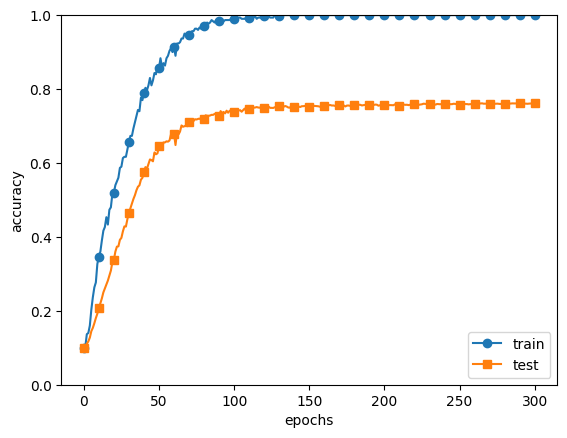

In [37]:
# coding: utf-8
import os
import sys
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net_extend import MultiLayerNetExtend
from common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 오버피팅을 재현하기 위해 학습 데이터 수를 줄임
x_train = x_train[:300]
t_train = t_train[:300]

# 드롭아웃 사용 유무와 비율 설정 ========================
use_dropout = True  # 드롭아웃을 쓰지 않을 때는 False
dropout_ratio = 0.2
# ====================================================

network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                              output_size=10, use_dropout=use_dropout, dropout_ration=dropout_ratio)
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=301, mini_batch_size=100,
                  optimizer='sgd', optimizer_param={'lr': 0.01}, verbose=True)
trainer.train()

train_acc_list, test_acc_list = trainer.train_acc_list, trainer.test_acc_list

# 그래프 그리기==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()


- 왼쪽은 드롭아웃 없이, 오른쪽은 드롭아웃을 적용한 결과 (dropout_ratio = 0.15)

<img src = "../deep_learning_images/fig 6-23.png" width = "70%" height = "70%" >

> 앙상블 학습(ensemble learning): 개별적으로 학습시킨 여러 모델의 출력을 평균 내어 추론하는 방식. 앙상블 학습은 드롭아웃과 밀접. 드롭아웃은 앙상블 학습과 같은 효과를 (대략) 하나의 네트워크로 구현했다고 생각.

## 6.5 적절한 하이퍼파라미터 값 찾기

- 하이퍼파라미터
    - 각 층의 뉴런수
    - 배치 크기
    - 매개변수 갱신 시의 학습률과 가중치 감소

- 값을 최대한 효율적으로 탐색하는 방법

### 6.5.1 검증 데이터

- 하이퍼파라미터의 성능을 평가할 때는 시험 데이터를 사용해서는 안 된다.
    <br/> **-> 시험 데이터를 사용하여 하이퍼파라미터를 조정하면 하이퍼 파라미터 값이 시험 데이터에 오버피팅되기 때문**

- **검증 데이터(validation data):** 하이퍼파라미터 전용 확인 데이터

- 훈련 데이터: 매개변수 학습
- 검증 데이터: 하이퍼파라미터 성능 평가
- 시험 데이터: 신경망의 범용 성능 평가(이상적으로 만지막 한 번만 이용)

In [ ]:
# MNIST 훈련, 시험으로만 분리 -> 사용자가 직접 검증 데이터 분리 필요
# 훈련 데이터 20%정도를 검증 데이터로 먼저 분리

(x_train, t_train), (x_test, t_test) = load_mnist()

# 훈련데이터를 뒤섞는다.(데이터셋이 치우쳐 있을지도 모르기 때문)
# np.random.shuffle
x_train, t_train = shuffle_dataset(x_train, t_train)

# 20%를 검증 데이터로 분할
validation_rate = 0.20
validation_num = int(x_train.shape[0] * validation_rate)

x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = x_train[validation_num:]

### 6.5.2 하이퍼파라미터 최적화

- 하이퍼파라미터 최적화의 핵심: 하이퍼파라미터의 '최적 값'이 존재하는 범위를 조금씩 줄여간다는 것
- 규칙적인 탐색보다는 무작위로 샘플링, 범위를 '대략적으로'지정하는 것이 효과적 -> 로그 스케일(log scale)
- 나쁠 듯한 값 일찍 포기. 학습을 위한 에폭을 작게 하여, 1회 평가에 걸리는 시간을 단축하는 것이 효과적

- 하이퍼파라미터 최적화

    0. 하이퍼 파라미터 값의 범위를 설정
    1. 설정된 범위에서 하이퍼파라미터의 값을 무작위로 추출
    2. 1단계에서 샘플링한 하이퍼파라미터 값을 사용하여 학습하고, 검증 데이터로 정확도를 평가(단, 에폭은 작게 설정)
    3. 1단계와 2단계를 특정 횟수(100회 등) 반복하여, 그 정확도의 결과를 보고 하이퍼파라미터의 범위를 좁힌다.

> 베이즈 최적화(Bayesian): 엄밀하고 효율적인 최적화. Practical Bayesian Optimization of Machine Learning Algorithms

### 6.5.3 하이퍼파라미터 최적화 구현하기

- MNIST 데이터셋 하이퍼파라미터 최적화
    - 학습률
    - 가중치 감소의 세기를 조절하는 계수(가중치 감소 계수)
    
- 0.001 ~ 1.000 사이 같은 로그 스케일 범위에서 무작위 추출 -> 10 ** np.random.uniform(-3.3)
    - 학습률 : 10^-6 ~ 10^-2
    - 가중치 감소의 세기를 조절하는 계수(가중치 감소 계수) : 10^-8 ~ 10^-4

In [50]:
weight_decay = 10 ** np.random.uniform(-8, -4)
lr = 10 ** np.random.uniform(-6, -2)

print(weight_decay)
print(lr)

1.1908053271861624e-06
1.0589834724456335e-06


val acc:0.08 | lr:1.9659247621920316e-06, weight decay:1.1659280288676146e-05
val acc:0.14 | lr:2.95847027472721e-05, weight decay:4.2089554391243975e-06
val acc:0.47 | lr:0.0031529836979630062, weight decay:2.2350836628808328e-06
val acc:0.11 | lr:8.159139412556507e-06, weight decay:7.05798486232608e-05
val acc:0.08 | lr:1.7596234934278275e-05, weight decay:1.492705543131117e-06
val acc:0.08 | lr:9.96050812565991e-05, weight decay:7.352404858251367e-05
val acc:0.13 | lr:0.00011512231084218318, weight decay:5.1233223371765495e-08
val acc:0.47 | lr:0.0024261745874926176, weight decay:5.229151171368202e-05
val acc:0.09 | lr:3.804889678596092e-06, weight decay:1.5373008841942315e-05
val acc:0.1 | lr:5.014570959915325e-05, weight decay:5.3352207219998956e-06
val acc:0.1 | lr:2.2052040556231067e-05, weight decay:1.543900240138028e-07
val acc:0.17 | lr:0.00036659792885466834, weight decay:1.8542381499376818e-08
val acc:0.76 | lr:0.007517211834180877, weight decay:8.987652650671399e-08
val ac

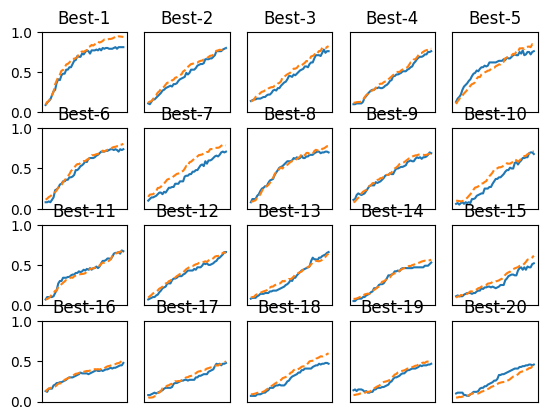

In [51]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.util import shuffle_dataset
from common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 결과를 빠르게 얻기 위해 훈련 데이터를 줄임
x_train = x_train[:500]
t_train = t_train[:500]

# 20%를 검증 데이터로 분할
validation_rate = 0.20
validation_num = int(x_train.shape[0] * validation_rate)
x_train, t_train = shuffle_dataset(x_train, t_train)
x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]


def __train(lr, weight_decay, epocs=50):
    network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                            output_size=10, weight_decay_lambda=weight_decay)
    trainer = Trainer(network, x_train, t_train, x_val, t_val,
                      epochs=epocs, mini_batch_size=100,
                      optimizer='sgd', optimizer_param={'lr': lr}, verbose=False)
    trainer.train()

    return trainer.test_acc_list, trainer.train_acc_list


# 하이퍼파라미터 무작위 탐색======================================
optimization_trial = 100
results_val = {}
results_train = {}
for _ in range(optimization_trial):
    # 탐색한 하이퍼파라미터의 범위 지정===============
    weight_decay = 10 ** np.random.uniform(-8, -4)
    lr = 10 ** np.random.uniform(-6, -2)
    # ================================================

    val_acc_list, train_acc_list = __train(lr, weight_decay)
    print("val acc:" + str(val_acc_list[-1]) + " | lr:" + str(lr) + ", weight decay:" + str(weight_decay))
    key = "lr:" + str(lr) + ", weight decay:" + str(weight_decay)
    results_val[key] = val_acc_list
    results_train[key] = train_acc_list

# 그래프 그리기========================================================
print("=========== Hyper-Parameter Optimization Result ===========")
graph_draw_num = 20
col_num = 5
row_num = int(np.ceil(graph_draw_num / col_num))
i = 0

for key, val_acc_list in sorted(results_val.items(), key=lambda x:x[1][-1], reverse=True):
    print("Best-" + str(i+1) + "(val acc:" + str(val_acc_list[-1]) + ") | " + key)

    plt.subplot(row_num, col_num, i+1)
    plt.title("Best-" + str(i+1))
    plt.ylim(0.0, 1.0)
    if i % 5: plt.yticks([])
    plt.xticks([])
    x = np.arange(len(val_acc_list))
    plt.plot(x, val_acc_list)
    plt.plot(x, results_train[key], "--")
    i += 1

    if i >= graph_draw_num:
        break

plt.show()


- Best-1(val acc:0.81) | lr:0.009555608009735152, weight decay:2.1240120884224644e-08
- Best-2(val acc:0.8) | lr:0.004400627259394357, weight decay:7.696183607880458e-06
- Best-3(val acc:0.76) | lr:0.007517211834180877, weight decay:8.987652650671399e-08
- Best-4(val acc:0.76) | lr:0.005600186176192418, weight decay:4.254765529297714e-05
- Best-5(val acc:0.76) | lr:0.006323546841015174, weight decay:3.04007909201333e-06

## 6.6 정리

- 신경망 학습에 중요한 기술
    - 매개변수 갱신 방법
    - 가중치의 초깃값을 설정하는 방법
    - 배치 정규화, 드롭아웃

> **이번 장에서 배운 내용**
* 계산 그래프를 이용하면 계산 과정을 시각적으로 파악할 수 있다.
* 계산 그래프의 노드는 국소적 계산으로 구성된다. 국소적 계산을 조합해 전체 계산을 구성한다.
* 계산 그래프의 순전파는 통상의 계산을 수행한다. 한편, 계산 그래프의 역전파로는 각 노드의 미분을 구할 수 있다.
* 신경망의 구성 요소를 계층으로 구현하여 기울기를 효율적으로 계산할 수 있다(오차역전파법).
* 수치 미분과 오차역전파법의 결과를 비교하면 오차역전파법의 구현에 잘못이 없는지 확인할 수 있다(기울기 확인).
